# Vignet parameter fitting

Here, we fit Vignet parameters (Murnagahn plots) using the data collected in VASP_data_aggregation_example.ipynb.  You see in this example how to go back to the primary files in order to extract missing data needed for the analysis.

In [1]:
import numpy as np
import pandas as pd
from collections import namedtuple

import crystaltools.vasprun_parser as vp
import crystaltools.fetch_tools as ft
import crystaltools.crystal_generator as cg
import crystaltools.murnagahn as murn

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

In [2]:
# Sane color scheme
Color = namedtuple('Color', ['red', 'blue', 'orange', 'cyan', 'green', 'yellow'])
sol = Color(red='#dc322f', blue='#268bd2', orange='#cb4b16', cyan='#2aa198', 
            green='#859900', yellow='#b58900')

## Load data from json file

In [3]:
# Load previously calculated json file
df_all = pd.DataFrame()
df_all = pd.read_json('aydin_data_summary.json')

# Replace missing values with sensible values
df_all['n2'].fillna(0, inplace=True)
df_all['el2'].fillna('None', inplace=True)

df_all.head()

,conv,cubic,e_0_energy,e_fr_energy,e_wo_entrp,el1,el2,encut,isif,kx,ky,kz,n1,n2,path,v1,v2,v3,volume
0,1,1,0.005804,-264.335934,-264.337385,Zr,None,400,0,8,8,8,32,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[8.6, 0.0, 0.0]","[0.0, 8.6, 0.0]","[0.0, 0.0, 8.6]",636.056000
1,1,1,-0.006999,-268.786227,-268.784477,Zr,None,400,0,8,8,8,32,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[8.84, 0.0, 0.0]","[0.0, 8.84, 0.0]","[0.0, 0.0, 8.84]",690.807104
10,1,1,-0.004235,-279.711073,-279.710014,Ru,None,400,0,8,8,8,32,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.26, 0.0, 0.0]","[0.0, 7.26, 0.0]","[0.0, 0.0, 7.26]",382.657176
100,1,1,-0.011961,-284.357077,-284.354086,Cr,F,400,0,8,8,8,32,1,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[6.86, 0.0, 0.0]","[0.0, 6.86, 0.0]","[0.0, 0.0, 6.86]",322.828856
1000,1,1,0.008310,-166.880212,-166.882290,La,C,400,0,8,8,8,32,1,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[10.56, 0.0, 0.0]","[0.0, 10.56, 0.0]","[0.0, 0.0, 10.56]",1177.583616


## Data exploration

We can take a quick look at the data that we had from before.  Here, I plot how many calculations are made for each matri and solute element.

In [4]:
def plot_groupby(df, field, fignum=1, figsize=(8,4)):
    gb = df_all.groupby(field)

    fig = plt.figure(fignum, figsize=figsize)
    fig.clf()
    ax = fig.add_subplot(111)
    gb.size().plot(ax=ax, kind='bar', color=sol.blue)
    
    return ax

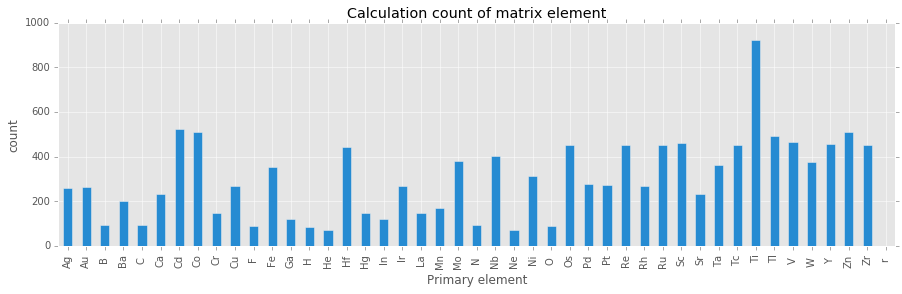

In [5]:
# plot calculation count of primary elements
ax = plot_groupby(df_all, 'el1', figsize=(15,4))
ax.set_xlabel('Primary element')
ax.set_ylabel('count')
ax.set_title('Calculation count of matrix element')

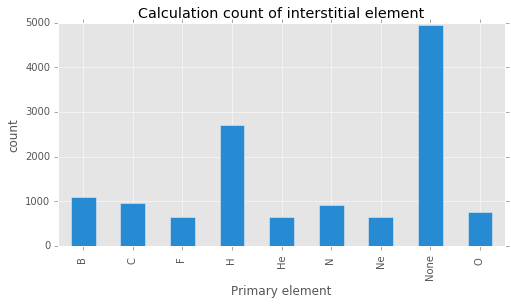

In [6]:
# Plot calculation count of interstitial elements
ax = plot_groupby(df_all, 'el2', figsize=(8,4))
ax.set_xlabel('Primary element')
ax.set_ylabel('count')
ax.set_title('Calculation count of interstitial element')

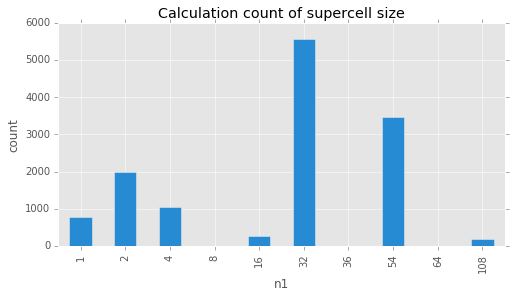

In [7]:
# Plot calculation count of the number of primary atoms
ax = plot_groupby(df_all, 'n1', figsize=(8,4))
ax.set_xlabel('n1')
ax.set_ylabel('count')
ax.set_title('Calculation count of supercell size')

## Grab a subset of the data

Here, we are interested in fitting the Vignet parameters for a particular matrix element and a particular interstitial element.  We want to compare apples to apples, so we need to make sure that we are grabbing the same parameters across the calculations.

Our filter are as follows:
- matrix: name of matrix element
- solname: name of interstitial element
- n1: number of matrix elements in the supercell
- n2: number of interstitial elements in the supercell
- isif: ISIF paramter
- cubic: boolean whether supercell is cubic or not

We also want to filter using some parameter we do not have in df_all:
- ismear: ISMEAR paramter
- magnetic: boolean whether the MAGMOM paramter is in the INCAR or not

In [8]:
# Parameters to be used as filter
matrix = 'Pd'
solname = 'H '
n1 = 32
n2 = 1
kx = 8
isif = 0
cubic = True
ismear = 2
magnetic = False

In [9]:
dfsub = df_all[(df_all.el1==matrix)&(df_all.el2==solname)&(df_all.n1==n1)&
               (df_all.n2==n2)&(df_all.kx==kx)&(df_all.isif==isif)].copy()
dfsub.reset_index(inplace=True)

In [10]:
# We can also add some new metadata to the table.  We can infer from n1 and cubic the 
# type of crystal structure
if (cubic)&(n1 in [4*(n)**3. for n in xrange(10)]):
    crystal_type = 'fcc'
elif (cubic)&(n1 in [2*(n)**3. for n in xrange(10)]):
    crystal_type = 'bcc'
elif cubic:
    crystal_type = 'cubic'
else:
    crystal_type = 'non-cubic'
    
dfsub['crystal_type'] = crystal_type

In [11]:
dfsub.head()

,index,conv,cubic,e_0_energy,e_fr_energy,e_wo_entrp,el1,el2,encut,isif,...,ky,kz,n1,n2,path,v1,v2,v3,volume,crystal_type
0,2611,1,1,-0.012474,-160.495703,-160.492584,Pd,H,400,0,...,8,8,32,1,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.5, 0.0, 0.0]","[0.0, 7.5, 0.0]","[0.0, 0.0, 7.5]",421.875,fcc
1,2612,1,1,-0.013960,-167.036526,-167.033036,Pd,H,400,0,...,8,8,32,1,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.7, 0.0, 0.0]","[0.0, 7.7, 0.0]","[0.0, 0.0, 7.7]",456.533,fcc
2,2613,1,1,-0.009884,-169.207792,-169.205321,Pd,H,400,0,...,8,8,32,1,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.9, 0.0, 0.0]","[0.0, 7.9, 0.0]","[0.0, 0.0, 7.9]",493.039,fcc
3,2614,1,1,-0.003630,-168.239171,-168.238263,Pd,H,400,0,...,8,8,32,1,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[8.1, 0.0, 0.0]","[0.0, 8.1, 0.0]","[0.0, 0.0, 8.1]",531.441,fcc
4,2615,1,1,-0.002534,-165.078823,-165.078190,Pd,H,400,0,...,8,8,32,1,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[8.3, 0.0, 0.0]","[0.0, 8.3, 0.0]","[0.0, 0.0, 8.3]",571.787,fcc


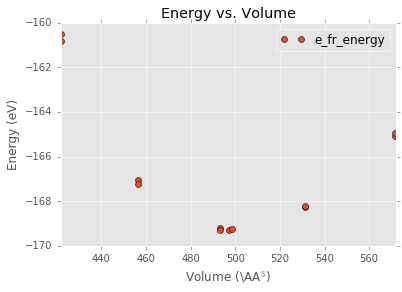

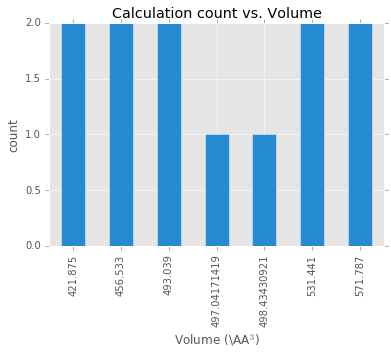

In [12]:
# Plot energy versus volume curve
fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(111)
dfsub.plot(ax=ax, x='volume', y='e_fr_energy', style='o')
ax.set_xlim([dfsub.volume.min(), dfsub.volume.max()]);
ax.set_xlabel('Volume (\AA$^3$)')
ax.set_ylabel('Energy (eV)')
ax.set_title('Energy vs. Volume')

# bar chart of calculation count versus volume
fig2 = plt.figure(2)
fig2.clf()
ax2 = fig2.add_subplot(111)
gb = dfsub.groupby('volume')
gb.size().plot(ax=ax2, kind='bar', color=sol.blue)
ax2.set_xlabel('Volume (\AA$^3$)')
ax2.set_ylabel('count')
ax2.set_title('Calculation count vs. Volume')

#### **Remark**: Notice that there are sometimes two calculations per volume.  These corresponds to octahedral and tetrahedral sites.  To decouple these, we need more information from the vasp jobs.

## Extract additional information from vasprun

We can do this by using the get_aggregate_data from the vasp_parser module.  We just need to define a new aggregation function. Since we are going back to the vasprun data, we might as well grab some other useful paramters along the way.  

#### New parameters to be fetched:
- a0: lattice paramter
- dnn: distance of the nearest neighbors
- Nnn: number of nearest neighbors
- ismear: ISMEAR parameter from INCAR
- sigma: SIGMA parameter from INCAR
- magmom: boolean stating whether the MAGMOM parameter exists in the INCAR

Here, I used my crystal generator module to center the solute atom in order to make sure that it is in the center and that there are no spurious results due to supercell periodicity.

The list of directories are given by a column on our existing dataframe.

In [13]:
def fxn_aggregator(file_path):
    with vp.VasprunHDFParser(directory='', filename=file_path) as vasprun:
        cellvec = vasprun.get_cell_vectors()
        element = vasprun.get_atoms()['atomtype']
        positions = vasprun.get_positions(state='final', coords='relative')
        rrel = np.array(positions[['rx', 'ry', 'rz']])

        # construct crystal
        crys = cg.Crystal()
        crys.cellvec = cellvec
        crys.itype = np.array(element).astype('int')
        crys.rrel = rrel

        # calculate lattice parameter
        if len(crys.xcar[crys.itype==1]) in [4*(n)**(3.) for n in xrange(10)]:
            nsc = (len(crys.xcar[crys.itype==1])/4)**(1./3.)
        elif len(crys.xcar[crys.itype==1]) in [2*(n)**(3.) for n in xrange(10)]:
            nsc = (len(crys.xcar[crys.itype==1])/2)**(1./3.)
        a0 = np.linalg.norm(cellvec[:,0]) / nsc

        # center cell on the interstitial
        r0 = crys.rcar[crys.itype==2]
        crys.translate_cartesian(r0)
        crys.center_atoms()

        # calculate nearest neighbor distances
        eps = 0.00001
        mask = (crys.itype==1)
        dist = (crys.xcar[mask]**2. + crys.ycar[mask]**2. + 
                crys.zcar[mask]**2.)**(1./2.)/a0
        dnn = min(dist)
        Nnn = len(dist[dist<= dnn+eps])
        
        # get ISMEAR and SIGMA parameters
        incar = vasprun.get_incar()
        incar = vasprun.get_incar()
        if 'ISMEAR' in incar.keys():
            ismear = incar.ISMEAR
        else:
            ismear = np.nan
            
        if 'SIGMA' in incar.keys():
            sigma = incar.SIGMA
        else:
            sigma = np.nan
            
        if 'MAGMOM' in incar.keys():
            magmom = True
        else:
            magmom = False

        # construct pandas series
        return pd.Series([file_path, a0, dnn, Nnn, ismear, sigma, magmom], 
                         index=['path', 'a0', 'dnn', 'Nnn', 'ismear', 'sigma', 'magmom'])

In [14]:
# get path list from dfsub
path_list = list(dfsub.path)

In [15]:
# apply fxn_aggregator to path_list
dfnn, bad_path = ft.get_aggregate_data(fxn_aggregator, path_list, verbose=True)

[====================] 100%.  - Processing /Volumes/Elements/python/aydin/vasprun_dump/h5files/vasprun_04440.h5

In [16]:
dfnn.head()

,Nnn,a0,dnn,ismear,magmom,path,sigma
0,4,3.75,0.060313,2,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,0.1
1,4,3.85,0.058710,2,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,0.1
2,4,3.95,0.057143,2,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,0.1
3,4,4.05,0.055576,2,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,0.1
4,4,4.15,0.054000,2,0,/Volumes/Elements/python/aydin/vasprun_dump/h5...,0.1


In [17]:
# Now, we just make an inner join of the new dataframe with dfsub
dfsub2 = pd.merge(dfsub, dfnn, how='inner', on='path')
dfsub2.head()

,index,conv,cubic,e_0_energy,e_fr_energy,e_wo_entrp,el1,el2,encut,isif,...,v2,v3,volume,crystal_type,Nnn,a0,dnn,ismear,magmom,sigma
0,2611,1,1,-0.012474,-160.495703,-160.492584,Pd,H,400,0,...,"[0.0, 7.5, 0.0]","[0.0, 0.0, 7.5]",421.875,fcc,4,3.75,0.060313,2,0,0.1
1,2612,1,1,-0.013960,-167.036526,-167.033036,Pd,H,400,0,...,"[0.0, 7.7, 0.0]","[0.0, 0.0, 7.7]",456.533,fcc,4,3.85,0.058710,2,0,0.1
2,2613,1,1,-0.009884,-169.207792,-169.205321,Pd,H,400,0,...,"[0.0, 7.9, 0.0]","[0.0, 0.0, 7.9]",493.039,fcc,4,3.95,0.057143,2,0,0.1
3,2614,1,1,-0.003630,-168.239171,-168.238263,Pd,H,400,0,...,"[0.0, 8.1, 0.0]","[0.0, 0.0, 8.1]",531.441,fcc,4,4.05,0.055576,2,0,0.1
4,2615,1,1,-0.002534,-165.078823,-165.078190,Pd,H,400,0,...,"[0.0, 8.3, 0.0]","[0.0, 0.0, 8.3]",571.787,fcc,4,4.15,0.054000,2,0,0.1


#### **Remark**:  Whether the solute is in the tetrahedral or octahedral site can be inferred from Nnn.  For fcc, Nnn=6 if octahedral, Nnn=4 if tetrahedral 

In [18]:
if crystal_type=='fcc':
    dict_Nnn = {'oct': 6, 'tet': 4}
elif crystal_type=='bcc':
    dict_Nnn = {'oct':2, 'tet':1}

## Fit Vignet curve and extract parameters

This is facilitated by the murnagahn module in crystaltools_local.

In [19]:
def fit_vignet(df, mask, plot=True):
    vignet = murn.fitMurnagahn()
    volume = df[mask].volume.as_matrix()
    energy = df[mask].e_fr_energy.as_matrix()
    vignet = murn.fitMurnagahn(volume, energy)
    vignet.fit_Vignet()

    if plot:
        vanaly = np.linspace(volume.min(), volume.max(), 1001)
        Eanaly = vignet.get_energy(vanaly)

        fig = plt.figure(1)
        fig.clf()
        ax = fig.add_subplot(111)
        ax.plot(volume, energy, 'ok', markerfacecolor=sol.blue, zorder=2)
        ax.plot(vanaly, Eanaly, '--', color=sol.red, zorder=1)
        ax.set_xlabel('Volume (\AA$^3$)')
        ax.set_ylabel('Energy (eV)')
        
    return pd.Series([vignet.E0, vignet.V0, vignet.B0, vignet.B0p], 
                    index=['E0', 'V0', 'B0', 'B0p'])

E0    -169.285059
V0     496.882551
B0     167.686209
B0p      5.602486
dtype: float64


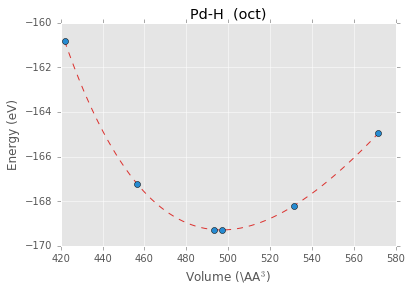

In [20]:
# Fit parameters for the octahedral site
site_type = 'oct'
mask = (dfsub2.Nnn==dict_Nnn[site_type])&(dfsub2.ismear==ismear)&(dfsub2.magmom==magnetic)
vignet_oct = fit_vignet(dfsub2, mask, plot=True)
plt.title(matrix + '-' + solname + ' (' + site_type + ')')
print vignet_oct

E0    -169.236801
V0     498.249970
B0     166.532039
B0p      5.601949
dtype: float64


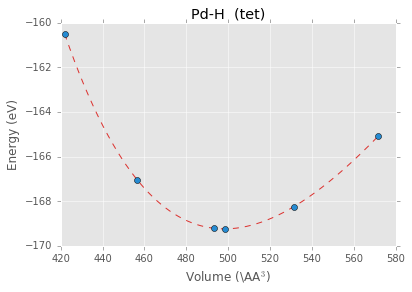

In [21]:
# Fit parameters for the octahedral site
site_type = 'tet'
mask = (dfsub2.Nnn==dict_Nnn[site_type])&(dfsub2.ismear==ismear)&(dfsub2.magmom==magnetic)
vignet_oct = fit_vignet(dfsub2, mask, plot=True)
plt.title(matrix + '-' + solname + ' (' + site_type + ')')
print vignet_oct

## Calculate Vignet parameters for reference pure matrix
Here, we basically do the same for the pure matrix.  We need to make a new aggregating function since dnn and Nnn makes no sense for the pure matrix.

In [22]:
def fxn_aggregator_pure(file_path):
    with vp.VasprunHDFParser(directory='', filename=file_path) as vasprun:
        pos = vasprun.get_positions(state='initial')
        cellvec = vasprun.get_cell_vectors()
        element = vasprun.get_atoms()['atomtype']
        positions = vasprun.get_positions(state='final', coords='relative')
        rrel = np.array(positions[['rx', 'ry', 'rz']])

        # construct crystal
        crys = cg.Crystal()
        crys.cellvec = cellvec
        crys.itype = np.array(element).astype('int')
        crys.rrel = rrel

        # calculate lattice parameter
        nsc = (len(crys.xcar[crys.itype==1])/4)**(1./3.)
        a0 = np.linalg.norm(cellvec[:,0]) / nsc

        # get ISMEAR and SIGMA parameters
        incar = vasprun.get_incar()
        incar = vasprun.get_incar()
        if 'ISMEAR' in incar.keys():
            ismear = incar.ISMEAR
        else:
            ismear = np.nan
            
        if 'SIGMA' in incar.keys():
            sigma = incar.SIGMA
        else:
            sigma = np.nan

        if 'MAGMOM' in incar.keys():
            magmom = True
        else:
            magmom = False
            
            
        # construct pandas series
        return pd.Series([file_path, a0, ismear, sigma, magmom], 
                         index=['path', 'a0', 'ismear', 'sigma', 'magmom'])

In [23]:
# (df_all.e_fr_energy<0) necessary because of some anomalous calculations
dfpure = df_all[(df_all.el1==matrix)&(df_all.el2=='None')&(df_all.n1==n1)&
                (df_all.n2==0)&(df_all.kx==kx)&(df_all.isif==isif)&
                (df_all.e_fr_energy<0)].copy()
dfpure.reset_index(inplace=True)
dfpure['crystal_type'] = crystal_type

In [24]:
path_list = list(dfpure.path)
df_extra, bad_path = ft.get_aggregate_data(fxn_aggregator_pure, path_list, verbose=True)

[====================] 100%.  - Processing /Volumes/Elements/python/aydin/vasprun_dump/h5files/vasprun_00640.h5

In [25]:
dfpure = pd.merge(dfpure, df_extra, how='inner', on='path')
dfpure.head()

,index,conv,cubic,e_0_energy,e_fr_energy,e_wo_entrp,el1,el2,encut,isif,...,path,v1,v2,v3,volume,crystal_type,a0,ismear,magmom,sigma
0,12035,1,1,-0.010956,-165.781882,-165.779143,Pd,None,400,0,...,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.90706, 0.0, 0.0]","[0.0, 7.90706, 0.0]","[0.0, 0.0, 7.90706]",494.362025,fcc,3.95353,2,0,0.1
1,12036,1,1,0.000000,-165.878573,-165.878573,Pd,None,400,0,...,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.90706, 0.0, 0.0]","[0.0, 7.90706, 0.0]","[0.0, 0.0, 7.90706]",494.362025,fcc,3.95353,-5,0,0.1
2,15,1,1,-0.018246,-157.926972,-157.922410,Pd,None,400,0,...,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.5, 0.0, 0.0]","[0.0, 7.5, 0.0]","[0.0, 0.0, 7.5]",421.875000,fcc,3.75000,2,0,0.1
3,16,1,1,-0.017510,-163.982023,-163.977645,Pd,None,400,0,...,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.7, 0.0, 0.0]","[0.0, 7.7, 0.0]","[0.0, 0.0, 7.7]",456.533000,fcc,3.85000,2,0,0.1
4,17,1,1,-0.011217,-165.780369,-165.777565,Pd,None,400,0,...,/Volumes/Elements/python/aydin/vasprun_dump/h5...,"[7.9, 0.0, 0.0]","[0.0, 7.9, 0.0]","[0.0, 0.0, 7.9]",493.039000,fcc,3.95000,2,0,0.1


E0    -165.781494
V0     494.234698
B0     168.142651
B0p      5.614821
dtype: float64


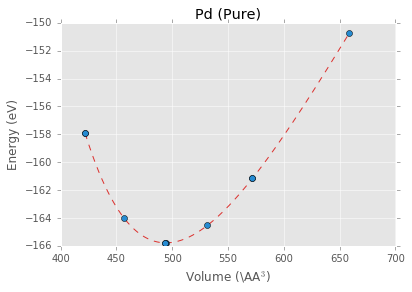

In [26]:
mask = (dfpure.ismear==2)&(dfpure.magmom==magnetic)
dfpure[mask]
vignet_pure = fit_vignet(dfpure, mask, plot=True)
plt.title(matrix + ' (Pure)')
print vignet_pure